cutoff_exit_performance_check():

TODO: On test data, run the model by iterating through exit layer indices.
Decide, based on entropy, whether to exit from a particular layer or not. Please utilize tensors after a layer for the next layer, if not exited. If print_per_layer_performance is True, please print accuracy and time for each layer. We want to see the printables for only one value. When plotting, you don't need to print these.

estimate_thresholds():

TODO: On validation data, for each layer, estimate entropy cutoff that gives the desired accuracy. Consider the samples exited and skip those samples when estimating the thresholds for the following layers.


1.   1(a) For a fixed value of cutoff, show performance for all layers.
2.   1(b) Plot overall accuracy vs cutoff, total time vs cutoff and total time vs overall accuracy.
3.   2(a) On validation data, estimate threshold for each layer based on desired minimum accuracy. Use said list of thresholds on test data.
4.   2(c) Vary the desired minimum accuracy and generate lists of thresholds. For the list of list of thresholds, plot total time vs overall accuracy.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import classification_report
from scipy.stats import entropy
from time import time
import torchvision

In [ ]:
num_classes = 10
num_layers = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
dataset = CIFAR10(root="./data", download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, transform=ToTensor())


# batch_size = 256
val_size = 5000
train_size = len(dataset) - val_size
_, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=val_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=10000, num_workers=4)

100%|██████████| 170498071/170498071 [00:06<00:00, 25014419.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class Branch(nn.Module):
    def __init__(self, in_channels, in_features):
        super(Branch, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels, out_channels=16, kernel_size=3, stride=2
        )
        self.bn = nn.BatchNorm2d(num_features=16)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
#@title Model

class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.in_channels = [32, 32, 64, 64, 128]
        self.in_features = [3600, 784, 784, 144, 144]
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, padding="same"
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding="same"
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.2)

        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding="same"
        )
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding="same"
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.3)

        self.conv5 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding="same"
        )
        self.conv6 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding="same"
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.bn5 = nn.BatchNorm2d(num_features=128)
        self.bn6 = nn.BatchNorm2d(num_features=128)
        self.dropout3 = nn.Dropout(p=0.4)

        self.branch1 = Branch(
            in_channels=self.in_channels[0], in_features=self.in_features[0]
        )
        self.branch2 = Branch(
            in_channels=self.in_channels[1], in_features=self.in_features[1]
        )
        self.branch3 = Branch(
            in_channels=self.in_channels[2], in_features=self.in_features[2]
        )
        self.branch4 = Branch(
            in_channels=self.in_channels[3], in_features=self.in_features[3]
        )
        self.branch5 = Branch(
            in_channels=self.in_channels[4], in_features=self.in_features[4]
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.bn7 = nn.BatchNorm1d(num_features=128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=128, out_features=num_classes)

        self.num_layers = num_layers

    def forward(self, tensor_after_previous_layer, exit_layer_idx=num_layers):
        if exit_layer_idx == 0:
            x = self.conv1(tensor_after_previous_layer)
            x = F.relu(x)
            tensor_after_layer = self.bn1(x)
            predicted_scores_from_layer = self.branch1(tensor_after_layer)

        elif exit_layer_idx == 1:
            x = self.conv2(tensor_after_previous_layer)
            x = F.relu(x)
            x = self.bn2(x)
            x = self.pool1(x)
            tensor_after_layer = self.dropout1(x)
            predicted_scores_from_layer = self.branch2(tensor_after_layer)

        elif exit_layer_idx == 2:
            x = self.conv3(tensor_after_previous_layer)
            x = F.relu(x)
            tensor_after_layer = self.bn3(x)
            predicted_scores_from_layer = self.branch3(tensor_after_layer)

        elif exit_layer_idx == 3:
            x = self.conv4(tensor_after_previous_layer)
            x = F.relu(x)
            x = self.bn4(x)
            x = self.pool2(x)
            tensor_after_layer = self.dropout2(x)
            predicted_scores_from_layer = self.branch4(tensor_after_layer)

        elif exit_layer_idx == 4:
            x = self.conv5(tensor_after_previous_layer)
            x = F.relu(x)
            tensor_after_layer = self.bn5(x)
            predicted_scores_from_layer = self.branch5(tensor_after_layer)

        elif exit_layer_idx == 5:
            x = self.conv6(tensor_after_previous_layer)
            x = F.relu(x)
            x = self.bn6(x)
            x = self.pool3(x)
            x = self.dropout3(x)

            x = self.flatten(x)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.fc3(x)
            x = F.relu(x)
            x = self.fc4(x)
            x = F.relu(x)
            x = self.bn7(x)
            tensor_after_layer = self.dropout4(x)
            predicted_scores_from_layer = self.fc5(tensor_after_layer)

        else:
            ValueError(f"exit_layer_idx {exit_layer_idx} should be int within 0 to 5")

        return tensor_after_layer, predicted_scores_from_layer

In [ ]:
model = Baseline().to(device)
model.load_state_dict(torch.load("cifar10_branchyNet_m.h5", map_location="cpu"))
model.eval()

Baseline(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [ ]:
def cutoff_exit_performance_check(cutoff, print_per_layer_performance=False, Debug=False):
    """
    TODO: On test data, run the model by iterating through exit layer indices.
    Decide, based on entropy, whether to exit from a particular layer or not.
    Please utilize tensors  after a layer for the next layer, if not exited.
    If print_per_layer_performance is True, please print accuracy and time
    for each layer. We want to see the printables for only one value. When
    plotting, you don't need to print these.
    """
    batch_number = 0
    acc = []
    sum_vals = []

    L0_Acc = []
    L1_Acc = []
    L2_Acc = []
    L3_Acc = []
    L4_Acc = []
    L5_Acc = []
    L0_Time = []
    L1_Time = []
    L2_Time = []
    L3_Time = []
    L4_Time = []
    L5_Time = []

    with torch.no_grad():
        start_total = time()
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            if (Debug is True):print('batch no.:', batch_number, 'with', data.shape[0], 'elements done')

            tensor_after_layer = data
            for exit_layer_idx in range(0, 5):  # Iterate through exit layer indices except fro the last layer

                # Starting time
                start_time = time()
                tensor_after_layer, predicted_scores_from_layer = model(tensor_after_layer, exit_layer_idx=exit_layer_idx)

                # Calculate loss and probabilities
                loss = F.cross_entropy(predicted_scores_from_layer, labels)
                probabilities = F.softmax(predicted_scores_from_layer, dim=1)

                # Calculate entropy
                entropy_val = entropy(probabilities.numpy(), axis=1)

                # If entropy is greater than the cutoff, then exit for those samples
                # This means that these are samples can be exited now
                # The rest of the samples are sent to the next layer
                result = entropy_val > cutoff

                # Sum of values which should exit
                sum_of_exit = np.sum(result)
                if (Debug is True):print(exit_layer_idx, sum_of_exit, 'are exited out of total', len(labels), ', and the number going to the next layer:', len(labels[~result]))

                # Ending time
                end_time = time()

                # These are the samples that have exited
                probabilities_exited = probabilities[result]
                labels_exited = labels[result]

                # Calculating accuracy and total time based on the exited samples
                if len(labels_exited) != 0:
                  predicted_classes = np.argmax(probabilities_exited, axis=1)
                  accuracy = np.sum(predicted_classes.numpy() == labels_exited.numpy()) / len(labels_exited)
                  acc.append(accuracy)
                  sum_vals.append(sum_of_exit)
                  time_val = end_time-start_time

                  if exit_layer_idx == 0:
                    L0_Acc.append(accuracy)
                    L0_Time.append(time_val)
                  if exit_layer_idx == 1:
                    L1_Acc.append(accuracy)
                    L1_Time.append(time_val)
                  if exit_layer_idx == 2:
                    L2_Acc.append(accuracy)
                    L2_Time.append(time_val)
                  if exit_layer_idx == 3:
                    L3_Acc.append(accuracy)
                    L3_Time.append(time_val)
                  if exit_layer_idx == 4:
                    L4_Acc.append(accuracy)
                    L4_Time.append(time_val)

                  if (Debug is True):
                    print('Accuracy:', round(accuracy, 2), ', Time: ', round(time_val, 2), 'for id:', exit_layer_idx,
                          'for batch:', batch_number, 'where,', sum_of_exit, 'are exited out of', len(labels), ', and the non exited are:', len(labels[result]))

                # Now updating non-exiting samples so that they stay
                # Since their entropy is less than cutoff
                # So, they need to go to the next layer
                tensor_after_layer = tensor_after_layer[~result]
                labels = labels[~result]

            for exit_layer_idx in range(5, 6):  # The last exit layer
                last_cutoff = 0
                # Starting time
                start_time = time()
                tensor_after_layer, predicted_scores_from_layer = model(tensor_after_layer, exit_layer_idx=exit_layer_idx)
                loss = F.cross_entropy(predicted_scores_from_layer, labels)
                probabilities = F.softmax(predicted_scores_from_layer, dim=1)
                entropy_val = entropy(probabilities.numpy(), axis=1)
                result = entropy_val > last_cutoff
                sum_of_exit = np.sum(result)
                if (Debug is True):print(exit_layer_idx, sum_of_exit, 'are exited out of total', len(labels), ', and the number going to the next layer:', len(labels[~result]))
                end_time = time()

                # These are the samples that have exited
                probabilities_exited = probabilities[result]
                labels_exited = labels[result]

                # Calculating accuracy and total time based on the exited samples
                if len(labels_exited) != 0:
                  predicted_classes = np.argmax(probabilities_exited, axis=1)
                  accuracy = np.sum(predicted_classes.numpy() == labels_exited.numpy()) / len(labels_exited)
                  acc.append(accuracy)
                  sum_vals.append(sum_of_exit)
                  time_val = end_time-start_time

                  if exit_layer_idx == 5:
                      L5_Acc.append(accuracy)
                      L5_Time.append(time_val)

                  if (Debug is True):
                    print('Accuracy:', round(accuracy, 2), ', Time: ', round(time_val, 2), 'for id:', exit_layer_idx,
                          'for batch:', batch_number, 'where,', sum_of_exit, 'are exited out of', len(labels), ', and the non exited are:', len(labels[result]))

            batch_number += 1

            # weighted average for calculating overall accuracy for exited samples
            # over all the layers
            if len(sum_vals) == 0:
              overall_accuracy = acc[0]
            else:
              if sum(sum_vals) != 0:
                overall_accuracy = sum(x * y for x, y in zip(acc, sum_vals)) / sum(sum_vals)
              else:
                overall_accuracy = sum(acc)/len(acc)
            if (Debug is True): print('Total samples exited for layers 0 through 5:', sum_vals,
                                      'with accuracies:', acc, ', with weighted sum:', overall_accuracy)

        end_total = time()
        total_time = end_total-start_total

        if print_per_layer_performance:
          print('Layer 0 Average Acc: ', str(L0_Acc), ', and it took on an average: ', str(L0_Time), ' seconds')
          print('Layer 1 Average Acc: ', str(L1_Acc), ', and it took on an average: ', str(L1_Time), ' seconds')
          print('Layer 2 Average Acc: ', str(L2_Acc), ', and it took on an average: ', str(L2_Time), ' seconds')
          print('Layer 3 Average Acc: ', str(L3_Acc), ', and it took on an average: ', str(L3_Time), ' seconds')
          print('Layer 4 Average Acc: ', str(L4_Acc), ', and it took on an average: ', str(L4_Time), ' seconds')
          print('Layer 5 Average Acc: ', str(L5_Acc), ', and it took on an average: ', str(L5_Time), ' seconds')
          print('Averaged over all layers and all samples for a cutoff: ', cutoff)
          print('overall_accuracy:', overall_accuracy, ', total_time:', total_time, 's, which averaged is:', str((total_time/data.shape[0])*1000), 'ms/sample!')

    return overall_accuracy, total_time

Task 1(a) Accuracy and inference time at each layer for c = 0.6

In [ ]:
cutoff = 0.6
overall_accuracy, total_time = cutoff_exit_performance_check(cutoff, print_per_layer_performance=True, Debug=True)

batch no.: 0 with 10000 elements done
0 5228 are exited out of total 10000 , and the number going to the next layer: 4772
Accuracy: 0.44 , Time:  9.82 for id: 0 for batch: 0 where, 5228 are exited out of 10000 , and the non exited are: 5228
1 1468 are exited out of total 4772 , and the number going to the next layer: 3304
Accuracy: 0.63 , Time:  4.95 for id: 1 for batch: 0 where, 1468 are exited out of 4772 , and the non exited are: 1468
2 199 are exited out of total 3304 , and the number going to the next layer: 3105
Accuracy: 0.62 , Time:  1.33 for id: 2 for batch: 0 where, 199 are exited out of 3304 , and the non exited are: 199
3 108 are exited out of total 3105 , and the number going to the next layer: 2997
Accuracy: 0.77 , Time:  2.06 for id: 3 for batch: 0 where, 108 are exited out of 3105 , and the non exited are: 108
4 40 are exited out of total 2997 , and the number going to the next layer: 2957
Accuracy: 0.7 , Time:  0.83 for id: 4 for batch: 0 where, 40 are exited out of 29

**Task** 1(b)
1. Plotting total time vs total accuracy (Scatter Plot)
2. Plotting total time vs cutoff
X - cutoff, y - time, varying cutoff from 0 to 1 at 0.01 increments
3. Plotting overall accuracy vs cutoff
X - cutoff, y - accuracy, varying cutoff from 0 to 1 at 0.01 increments

In [ ]:
iteration_limit = 100

# Iterating from 0.001 to log2(10)
# I didn't iterate from 0 since doing that leads to dividing by zero error
cutoff_values = np.linspace(0.001, np.log2(num_classes), iteration_limit)

acc_vals = []
time_vals = []
i = 0
for cutoff_value in cutoff_values:
  overall_accuracy, total_time = cutoff_exit_performance_check(cutoff_value, print_per_layer_performance=True, Debug=False)
  acc_vals.append(overall_accuracy)
  time_vals.append(total_time)
  i += 1
  print(i, '/', str(iteration_limit), ' done for cutoff value: ', round(cutoff_value, 2), ' which has acc: ', round(overall_accuracy, 2),
        ' and took: ', round(total_time, 2), 's total, and', round((total_time/10000)*1000, 2), 'ms/sample')

acc_vals_np = np.array(acc_vals)
time_vals_np = np.array(time_vals)
cutoff_np = np.array(cutoff_values)

np.save('acc_1_'  + str(iteration_limit)  +'.npy', acc_vals_np)
np.save('time_1_' + str(iteration_limit)  +'.npy', time_vals_np)
np.save('cutoff_1_'+str(iteration_limit)  +'.npy', cutoff_np)

plt.scatter(time_vals, acc_vals)
plt.title('Part 1(b).1')
plt.xlabel('Total Time')
plt.ylabel('Overall Accuracy')
plt.show()

plt.plot(cutoff_values, time_vals)
plt.title('Part 1(b).2')
plt.ylabel('Total Time')
plt.xlabel('Cutoff')
plt.show()

plt.plot(cutoff_values, acc_vals)
plt.title('Part 1(b).3')
plt.ylabel('Overall Accuracy')
plt.xlabel('Cutoff')
plt.show()

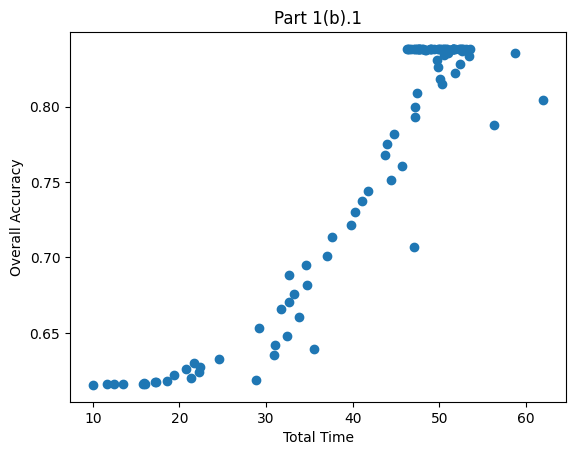

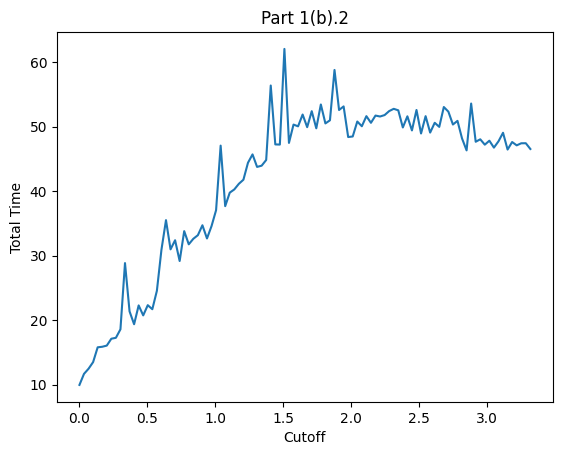

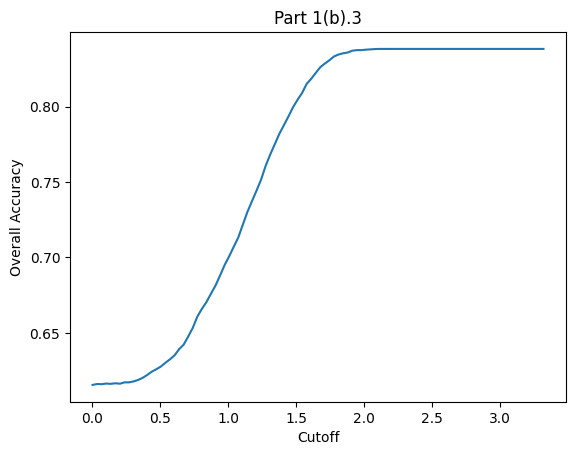

In [ ]:
# Re-plotting here to not repeat the above cell
iteration_limit = 100

acc_vals_np = np.load('acc_1_'  + str(iteration_limit)  +'.npy')
time_vals_np= np.load('time_1_' + str(iteration_limit)  +'.npy')
cutoff_np   = np.load('cutoff_1_'+str(iteration_limit)  +'.npy')

plt.scatter(time_vals_np, acc_vals_np)
plt.title('Part 1(b).1')
plt.xlabel('Total Time')
plt.ylabel('Overall Accuracy')
plt.show()

plt.plot(cutoff_np, time_vals_np)
plt.title('Part 1(b).2')
plt.ylabel('Total Time')
plt.xlabel('Cutoff')
plt.show()

plt.plot(cutoff_np, acc_vals_np)
plt.title('Part 1(b).3')
plt.ylabel('Overall Accuracy')
plt.xlabel('Cutoff')
plt.show()

**Task 1(b).4**

**Describe which threshold you think the model works best in terms of
both inference time and accuracy.**

According to me, based on above, a threshold of ~2 works best for least time and accuracy above 0.8.

# Task 2

## (a)1 **Estimating the thresholds for the validation data**

In [ ]:
def estimate_thresholds(desired_accuracy, Debug=False):
    """
    TODO: On validation data, for each layer, estimate entropy cutoff that
    gives the desired accuracy. Consider the samples exited and skip those
    samples when estimating the thresholds for the following layers.
    """
    estimated_thresholds = []

    batch_number = 0
    acc = []
    sum_vals = []

    with torch.no_grad():
        start_total = time()
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            if (Debug is True): print('Batch no.: ', batch_number+1, '/ ', len(val_loader), ' now processing')

            tensor_after_layer = data
            for exit_layer_idx in range(0, 6):  # Iterate through exit layer indices
                cutoff = np.log2(num_classes)

                start_time = time()
                tensor_after_layer, predicted_scores_from_layer = model(tensor_after_layer, exit_layer_idx=exit_layer_idx)
                loss = F.cross_entropy(predicted_scores_from_layer, labels)
                probabilities = F.softmax(predicted_scores_from_layer, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
                result = entropy > cutoff
                sum_of_trues = torch.sum(result).item()
                end_time = time()
                tensor_after_layer_exited = tensor_after_layer[~result]
                probabilities_exited = probabilities[~result]
                labels_exited = labels[~result]

                if len(labels_exited) != 0:
                  predicted_classes = torch.argmax(probabilities_exited, dim=1)
                  accuracy = torch.sum(predicted_classes == labels_exited).item() / len(labels_exited)
                  time_val = end_time-start_time

                  if accuracy >= desired_accuracy:
                    acc.append(accuracy)
                    sum_vals.append(sum_of_trues)
                    if (Debug is True): print('First cutoff:', round(cutoff, 2),
                                              ', Accuracy: ', round(accuracy, 2),
                                              ', Time: ', round(time_val, 2),
                                              ' for id: ', exit_layer_idx,
                                              ' for batch: ', batch_number,
                                              ' where, ', sum_of_trues,
                                              ' are not exited out of ', len(labels),
                                              ', and the number exited: ', len(labels[~result]))
                    estimated_thresholds.append(cutoff)
                  else:
                    while accuracy < desired_accuracy:
                      cutoff = cutoff * 0.9
                      # print(cutoff)
                      start_time = time()
                      result = entropy > cutoff
                      sum_of_trues = torch.sum(result).item()
                      end_time = time()

                      tensor_after_layer_exited = tensor_after_layer[~result]
                      probabilities_exited = probabilities[~result]
                      labels_exited = labels[~result]

                      if len(labels_exited) != 0:
                        predicted_classes = torch.argmax(probabilities_exited, dim=1)
                        accuracy = torch.sum(predicted_classes == labels_exited).item() / len(labels_exited)
                        time_val = end_time-start_time

                      if accuracy < desired_accuracy and cutoff < 0.001:
                        break

                    acc.append(accuracy)
                    sum_vals.append(sum_of_trues)
                    if (Debug is True):
                      print('Successive cutoff:', round(cutoff, 2) ,
                            ', Accuracy: ', round(accuracy, 2),
                            ', Time: ', round(time_val, 2),
                            ' for id: ', exit_layer_idx,
                            ' for sample: ', batch_number,
                            ' where, ', sum_of_trues,
                            ' are not exited out of ', len(labels),
                            ', and the number exited: ', len(labels[~result]))
                    estimated_thresholds.append(cutoff)

                tensor_after_layer = tensor_after_layer[result]
                labels = labels[result]

            # weighted average for a given batch and then average over all the batches
            if len(sum_vals) == 0:# and sum_vals[0] == 0:
              overall_accuracy = acc[0]
            else:
              if sum(sum_vals) != 0:
                overall_accuracy = sum(x * y for x, y in zip(acc, sum_vals)) / sum(sum_vals)
              else:
                overall_accuracy = sum(acc)/len(acc)
            if (Debug is True): print('Total sum_vals: ', len(sum_vals), ', and overall_accuracy: ', overall_accuracy)

            batch_number += 1

    return estimated_thresholds, overall_accuracy

In [ ]:
estimated_thresholds, acc = estimate_thresholds(0.8, Debug= True)
# Setting the final layer cutoff to 0
estimated_thresholds[5] = 0
print('There are a total of ', len(estimated_thresholds), ' estimated thresholds: ', estimated_thresholds)
print('The overall accuracy is ', acc)

Batch no.:  1 /  1  now processing
Successive cutoff: 0.84 , Accuracy:  0.8 , Time:  0.0  for id:  0  for sample:  0  where,  2616  are not exited out of  5000 , and the number exited:  2384
Successive cutoff: 1.29 , Accuracy:  0.8 , Time:  0.0  for id:  1  for sample:  0  where,  1349  are not exited out of  2616 , and the number exited:  1267
Successive cutoff: 0.84 , Accuracy:  0.8 , Time:  0.0  for id:  2  for sample:  0  where,  993  are not exited out of  1349 , and the number exited:  356
Successive cutoff: 1.04 , Accuracy:  0.82 , Time:  0.0  for id:  3  for sample:  0  where,  796  are not exited out of  993 , and the number exited:  197
Successive cutoff: 0.76 , Accuracy:  0.82 , Time:  0.0  for id:  4  for sample:  0  where,  642  are not exited out of  796 , and the number exited:  154
Successive cutoff: 0.84 , Accuracy:  0.84 , Time:  0.0  for id:  5  for sample:  0  where,  538  are not exited out of  642 , and the number exited:  104
Total sum_vals:  6 , and overall_accu

# Task 2

## (a)2 **Estimating the inference time with these thresholds**

In [ ]:
def inference_thresholds(thresholds, Debug=False):
    batch_number = 0
    with torch.no_grad():
      start_total = time()
      for data, labels in val_loader:
        data = data.to(device)
        labels = labels.to(device)
        if (Debug is True): print('Batch no.: ', batch_number+1, '/ ', len(val_loader), ' now processing')

        tensor_after_layer = data
        for exit_layer_idx in range(0, 6):  # Iterate through exit layer indices
          start_time = time()
          tensor_after_layer, predicted_scores_from_layer = model(tensor_after_layer, exit_layer_idx=exit_layer_idx)
          loss = F.cross_entropy(predicted_scores_from_layer, labels)
          probabilities = F.softmax(predicted_scores_from_layer, dim=1)
          entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
          result = entropy > thresholds[batch_number*6+exit_layer_idx]
          # print(thresholds[batch_number*6+exit_layer_idx], result)
          sum_of_trues = torch.sum(result).item()
          tensor_after_layer_exited = tensor_after_layer[~result]
          probabilities_exited = probabilities[~result]
          labels_exited = labels[~result]
          if len(labels_exited) != 0:
            predicted_classes = torch.argmax(probabilities_exited, dim=1)
            accuracy = torch.sum(predicted_classes == labels_exited).item() / len(labels_exited)
            end_time = time()
            time_val = end_time-start_time
            if (Debug is True):
                print('Entropy cutoff:', round(thresholds[batch_number*6+exit_layer_idx], 2),
                      ', Accuracy: ', round(accuracy, 2),
                      ', Time: ', round(time_val, 2),
                      ' for id: ', exit_layer_idx,
                      ' for batch: ', batch_number,
                      ' where, ', sum_of_trues,
                      ' are not exited out of ', len(labels),
                      ', and the number exited: ', len(labels[~result]))
          tensor_after_layer = tensor_after_layer[result]
          labels = labels[result]
        batch_number += 1
      end_total = time()
      inference_time = end_total-start_total

    return inference_time

In [ ]:
Debug=False
inference_time = inference_thresholds(estimated_thresholds, Debug=Debug)
if Debug==True: print('Total inference time with print statements: ', inference_time, ' which comes down to ', inference_time/val_size, ' seconds per sample.')
else: print('Total inference time (no printing during inference): ', inference_time, ' which comes down to ', inference_time/val_size, ' seconds per sample.')

Total inference time (no printing during inference):  10.199470043182373  which comes down to  0.0020398940086364748  seconds per sample.


The inference time is about 7 - 8 seconds without the print statements, and it is about 8-9 seconds with the debugging print statements for all of the validation data.

Per sample, this averages down to ~2 ms per sample.

# Task 2

## (b)1 **Estimating the inference with different accuracy thresholds**

In [ ]:
iteration_limit = 5
acc_thresholds = np.linspace(0.8, 1, iteration_limit)

final_thresholds = []
final_accuracies = []
final_infer_time = []
iteration_val = 0
for iteration in acc_thresholds:
  estimated_thresholds, acc = estimate_thresholds(iteration, Debug= False)
  estimated_thresholds[5] = 0
  print('For accuracy threshold of: ', round(iteration, 3), ', there are total ', len(estimated_thresholds), ' estimated thresholds with overall accuracy: ', round(acc, 3))
  Debug=False
  inference_time = inference_thresholds(estimated_thresholds, Debug=False)
  print('For iteration ',  iteration_val, ', total inference time: ', round(inference_time, 3), 's which is ', round((inference_time/val_size)*1000, 3), ' ms per sample.')
  final_thresholds.append(estimated_thresholds)
  final_accuracies.append(acc)
  final_infer_time.append(inference_time)
  iteration_val += 1

estimated_thresholds = np.array([np.array(xi) for xi in final_thresholds])
np.save('estimated_thresholds.npy', estimated_thresholds)

For accuracy threshold of:  0.8 , there are total  6  estimated thresholds with overall accuracy:  0.808
For iteration  0 , total inference time:  10.979 s which is  2.196  ms per sample.
For accuracy threshold of:  0.85 , there are total  6  estimated thresholds with overall accuracy:  0.86
For iteration  1 , total inference time:  11.975 s which is  2.395  ms per sample.
For accuracy threshold of:  0.9 , there are total  6  estimated thresholds with overall accuracy:  0.904
For iteration  2 , total inference time:  15.332 s which is  3.066  ms per sample.
For accuracy threshold of:  0.95 , there are total  6  estimated thresholds with overall accuracy:  0.952
For iteration  3 , total inference time:  16.437 s which is  3.287  ms per sample.
For accuracy threshold of:  1.0 , there are total  6  estimated thresholds with overall accuracy:  0.996
For iteration  4 , total inference time:  20.772 s which is  4.154  ms per sample.


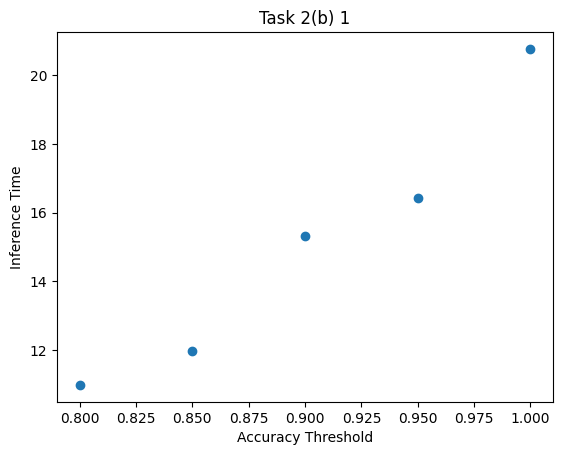

In [ ]:
plt.scatter(acc_thresholds, final_infer_time)
plt.title('Task 2(b) 1')
plt.ylabel('Inference Time')
plt.xlabel('Accuracy Threshold')
plt.show()

Based on this, I choose a cutoff of 0.85 because while the values are increasing somewhat linearly, there is a slight drop for that value.

# Task 2

## (b)2 **Using the best threshold, find the accuracy and inference time on the test data.**

In [ ]:
def inference_thresholds_test(thresholds, Debug=False):
    batch_number = 0
    accs = []
    sum_vals = []
    thresholds = torch.from_numpy(thresholds)
    with torch.no_grad():
      start_total = time()
      for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        if (Debug is True): print('Batch no.: ', batch_number+1, '/ ', len(test_loader), ' now processing')

        tensor_after_layer = data
        for exit_layer_idx in range(0, 6):  # Iterate through exit layer indices
          start_time = time()
          tensor_after_layer, predicted_scores_from_layer = model(tensor_after_layer, exit_layer_idx=exit_layer_idx)
          loss = F.cross_entropy(predicted_scores_from_layer, labels)
          probabilities = F.softmax(predicted_scores_from_layer, dim=1)
          entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=1)
          # print(thresholds[exit_layer_idx])
          result = entropy > thresholds[exit_layer_idx]
          sum_of_trues = torch.sum(result).item()
          tensor_after_layer_exited = tensor_after_layer[~result]
          probabilities_exited = probabilities[~result]
          labels_exited = labels[~result]
          # print(len(labels_exited), 10000-sum_of_trues)
          if len(labels_exited) != 0:
            predicted_classes = torch.argmax(probabilities_exited, dim=1)
            accuracy = torch.sum(predicted_classes == labels_exited).item() / len(labels_exited)
            end_time = time()
            time_val = end_time-start_time
            if (Debug is True):
                print('Entropy cutoff:', thresholds[exit_layer_idx].item(),
                      ', Accuracy: ', round(accuracy, 2),
                      ', Time: ', round(time_val, 2),
                      ' for id: ', exit_layer_idx,
                      ' for batch: ', batch_number,
                      ' where, ', sum_of_trues,
                      ' are not exited out of ', len(labels),
                      ', and the number exited: ', len(labels[~result]))
          tensor_after_layer = tensor_after_layer[result]
          labels = labels[result]
          accs.append(accuracy)
          sum_vals.append(10000-sum_of_trues)
        # weighted average for a given batch and then average over all the batches
        if len(sum_vals) == 0:# and sum_vals[0] == 0:
          overall_accuracy = acc[0]
        else:
          if sum(sum_vals) != 0:
            overall_accuracy = sum(x * y for x, y in zip(accs, sum_vals)) / sum(sum_vals)
          else:
            overall_accuracy = sum(accs)/len(accs)
        if (Debug is True): print('Total sum_vals: ', len(sum_vals), (sum_vals), ', and overall_accuracy: ', overall_accuracy)

        batch_number += 1
      end_total = time()
      inference_time = end_total-start_total

    return inference_time, overall_accuracy, accs

In [ ]:
# Accuracy threshold obtained from validation data
accuracy_threshold = 0.85
estimated_thresholds = np.load('estimated_thresholds.npy')
print('Estimated Thresholds:', estimated_thresholds[1])
print('Using the test data with an accuracy threshold of: ', accuracy_threshold)
inference_time, acc_1, accs = inference_thresholds_test(estimated_thresholds[1], Debug=True)
# print(len(accs), acc_1, accs)
print('The total inference time: ', round(inference_time, 3), ' s, which is ', round((inference_time/10000)*1000, 3), ' ms per sample.')
print('So, the overall acc is: ', round(acc_1, 3), ' and the average inference time per test data sample is: ', round((inference_time/10000)*1000, 3), ' ms!')

Estimated Thresholds: [0.55400398 1.04245624 0.68395554 0.55400398 0.68395554 0.        ]
Using the test data with an accuracy threshold of:  0.85
Batch no.:  1 /  1  now processing
Entropy cutoff: 0.5540039843166377 , Accuracy:  0.87 , Time:  6.77  for id:  0  for batch:  0  where,  6418  are not exited out of  10000 , and the number exited:  3582
Entropy cutoff: 1.0424562356247216 , Accuracy:  0.85 , Time:  6.68  for id:  1  for batch:  0  where,  3865  are not exited out of  6418 , and the number exited:  2553
Entropy cutoff: 0.6839555361933799 , Accuracy:  0.84 , Time:  1.93  for id:  2  for batch:  0  where,  2887  are not exited out of  3865 , and the number exited:  978
Entropy cutoff: 0.5540039843166377 , Accuracy:  0.86 , Time:  3.06  for id:  3  for batch:  0  where,  2609  are not exited out of  2887 , and the number exited:  278
Entropy cutoff: 0.6839555361933799 , Accuracy:  0.84 , Time:  1.12  for id:  4  for batch:  0  where,  1927  are not exited out of  2609 , and the 